In [1]:
import os
import cv2
import shutil
import PIL
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import model_selection
from pathlib import Path
from PIL import Image
from tqdm import tqdm

In [3]:
BASE_DIR = '../../dataset/'
SAVED_MODEL_DIR = BASE_DIR + '../model'
DATASET_DIR = BASE_DIR + 'dataset_nuovo/'
DATA_DIR = Path(DATASET_DIR)
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_SIZE = 256
EPOCHS = 20
BATCH_SIZE = 128

In [6]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    seed = 123)

ds_size = len(list(ds))
print(f'[DEBUG] - ds_size: {ds_size}')
class_names = ds.class_names
ds = ds.shuffle(10000, seed=12)
print(f'[INFO] - Class names: {class_names}')

Found 13586 files belonging to 3 classes.
[DEBUG] - ds_size: 13586
[INFO] - Class names: ['correctly-masked', 'not-masked', 'uncorrectly-masked']


In [7]:
x = []
y = []
for image, label in tqdm(ds.unbatch().take(-1)):
    img = image.numpy().astype("uint8")
    x.append(img)
    label = label.numpy()
    y.append(label)

x = np.array(x)
y = np.array(y)

13586it [00:31, 425.40it/s] 


In [8]:
x_train, x_val_test, y_train, y_val_test = model_selection.train_test_split(x, y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = model_selection.train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42)

In [9]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0

In [10]:
start_time = time.time()
epochs = EPOCHS
history = model.fit(
  x_train, y_train,
  validation_data = (x_val, y_val),
  epochs = epochs
)
model.save(SAVED_MODEL_DIR)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/20
255/255 [==============================] - 214s 837ms/step - loss: 0.2867 - accuracy: 0.8581 - val_loss: 0.0791 - val_accuracy: 0.9768
Epoch 2/20
255/255 [==============================] - 239s 939ms/step - loss: 0.0309 - accuracy: 0.9921 - val_loss: 0.0366 - val_accuracy: 0.9901
Epoch 3/20
255/255 [==============================] - 242s 949ms/step - loss: 0.0217 - accuracy: 0.9930 - val_loss: 0.0186 - val_accuracy: 0.9948
Epoch 4/20
255/255 [==============================] - 246s 965ms/step - loss: 0.0108 - accuracy: 0.9972 - val_loss: 0.0181 - val_accuracy: 0.9948
Epoch 5/20
255/255 [==============================] - 260s 1s/step - loss: 0.0083 - accuracy: 0.9971 - val_loss: 0.0163 - val_accuracy: 0.9952
Epoch 6/20
255/255 [==============================] - 253s 991ms/step - loss: 0.0166 - accuracy: 0.9951 - val_loss: 0.0181 - val_accuracy: 0.9948
Epoch 7/20
255/255 [==============================] - 251s 986ms/step - loss: 0.0080 - accuracy: 0.9973 - val_loss: 0.0192 - va

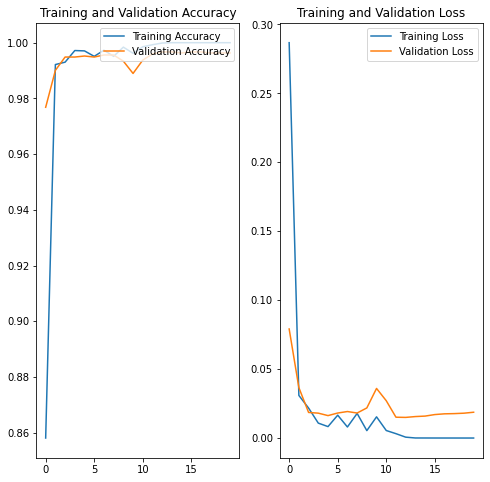

In [11]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
predictions = np.argmax(model.predict(x_test), axis=-1)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, 
                            target_names = ['correctly-masked (Class 0)','not-masked (Class 1)', 'uncorrectly-masked (Class 2)']))

                              precision    recall  f1-score   support

  correctly-masked (Class 0)       0.99      1.00      1.00      1161
        not-masked (Class 1)       1.00      0.99      0.99       392
uncorrectly-masked (Class 2)       1.00      0.99      1.00      1165

                    accuracy                           1.00      2718
                   macro avg       1.00      1.00      1.00      2718
                weighted avg       1.00      1.00      1.00      2718

